-----

# Crossvalidation for bandwith/regularisation selection

In [ ]:
_model_ =  models.lsmodels[2][0]
params = tuple(models.lsmodels[2][1].values())

In [24]:
from modules import *
from functions import *
L = np.random.rand(100, 100)
L = np.dot(L, L.T)  # Make it positive semi-definite


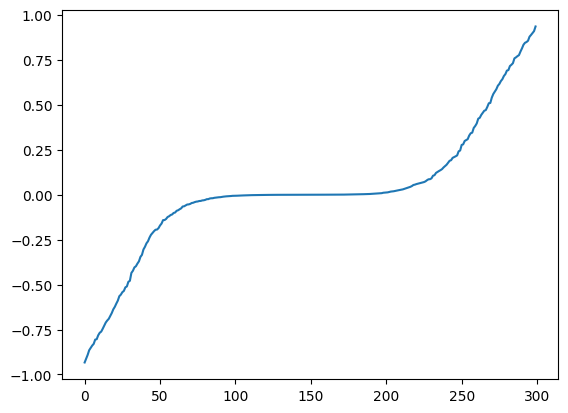

In [8]:
import models.models_classes as models
_model_, model_params = models.lsmodels[0]
d = 10
n = 150; m = n
kernel_name = 'sqeuclidean'
X = _model_(**model_params)(d).sample_X(n)
Y = _model_(**model_params)(d).sample_Y(m)

n = len(X); m = len(Y)
fullsample = np.concatenate([X, Y])

pairwise_dists = cdist(fullsample, fullsample, kernel_name)
bandwidth = 2 * np.median(pairwise_dists[pairwise_dists > 0]) 
obs_value = defaultdict()
p_values = []
permuted_values = defaultdict(list)
kernel_matrix  =  np.exp( - pairwise_dists / (bandwidth)) 
kxx, kyy, kxy = split_kernel(kernel_matrix, n, m)
mX, mY = get_mvecs_X_Y(kxx, kxy, kyy)
SX, SY = get_Smats_X_Y(kxx, kxy, kyy)
SX = .5*(SX + SY); mX = .5*(mX + mY) 
# eigvals_SX ,eigvecs_SX = SX_ED_from_kernel_via_svd(kernel_matrix[:,:n])
eigvals_SX, eigvecs_SX=np.linalg.eigh(SX)
r = 1e-5
inv_sqrtm_SX = inv_sqrtm_ED((eigvals_SX + r, eigvecs_SX))
innerHSmat_eigvals = np.linalg.eigvalsh(inv_sqrtm_SX @ (SY - SX) @ inv_sqrtm_SX)
plt.plot(innerHSmat_eigvals)


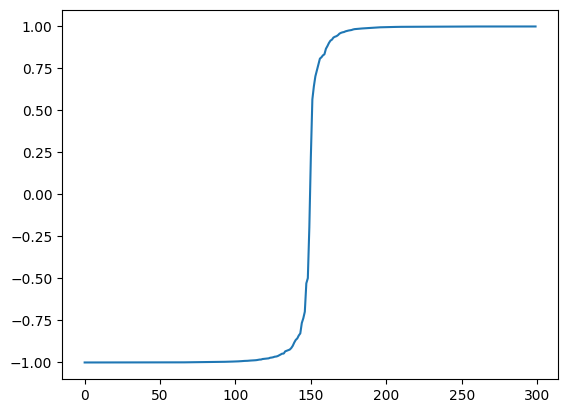

In [20]:
r = 1e-10
inv_sqrtm_SX = inv_sqrtm_ED((eigvals_SX + r, eigvecs_SX))
innerHSmat_eigvals = np.linalg.eigvalsh(inv_sqrtm_SX @ (SY - SX) @ inv_sqrtm_SX)
plt.plot(innerHSmat_eigvals)

In [81]:
np.random.shuffle(fullsample)

In [ ]:
np.logspace(-3, 3, 7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

Running model: MODEL_6 with parameters: {'eps': 0.1}
   Running band_factor = 0.001, ridge = 1e-09
   Running band_factor = 0.001, ridge = 1e-08
   Running band_factor = 0.001, ridge = 1e-07
   Running band_factor = 0.001, ridge = 1e-06
   Running band_factor = 0.001, ridge = 1e-05
   Running band_factor = 0.001, ridge = 0.0001
   Running band_factor = 0.001, ridge = 0.001
   Running band_factor = 0.001, ridge = 0.01
   Running band_factor = 0.001, ridge = 0.1
   Running band_factor = 0.01, ridge = 1e-09
   Running band_factor = 0.01, ridge = 1e-08
   Running band_factor = 0.01, ridge = 1e-07
   Running band_factor = 0.01, ridge = 1e-06
   Running band_factor = 0.01, ridge = 1e-05
   Running band_factor = 0.01, ridge = 0.0001
   Running band_factor = 0.01, ridge = 0.001
   Running band_factor = 0.01, ridge = 0.01
   Running band_factor = 0.01, ridge = 0.1
   Running band_factor = 0.1, ridge = 1e-09
   Running band_factor = 0.1, ridge = 1e-08
   Running band_factor = 0.1, ridge = 1e-07


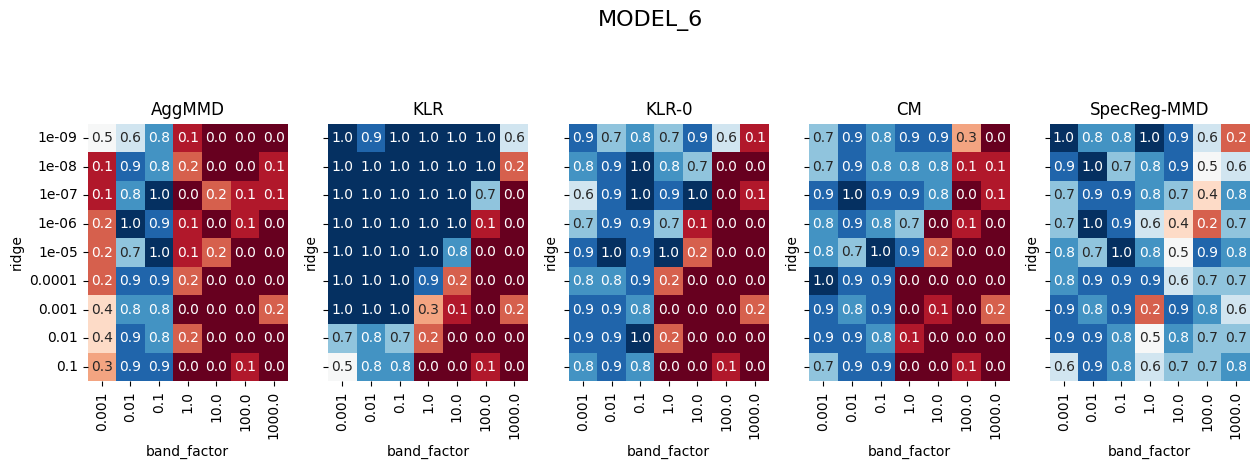

In [26]:
from modules import *
from functions import *
import models.models_classes as models

NUM_CORES = 8

n, d = 50, 250
N_iters = 10
num_permutations = 250
kernel_name = 'sqeuclidean'

# for _model_,model_params in [models.lsmodels[1], models.lsmodels[2], models.lsmodels[3]]:
# for _model_, model_params in [(models.MODEL_6, {'eps': 0.1})]:
for _model_, model_params in [(models.MODEL_6, {'eps': 0.1})]:
    tqdm.write(f"Running model: {_model_.__name__} with parameters: {model_params}")
    results = []
    for band_factor in np.logspace(-3, 3, 7):
        for ridge in np.logspace(-9, -1, 9):
            tqdm.write(f"   Running band_factor = {band_factor}, ridge = {ridge}" )
            args = (n, d, _model_, model_params, num_permutations, N_iters, NUM_CORES, kernel_name, [ridge], [band_factor], True)
            out = run_fast_parallel(*args)
            test_names = out[0].keys()
            for test_name in test_names:
                decisions = [_[test_name] for _ in out]
                results += [[band_factor, ridge, test_name, np.mean(decisions)]]

    data = pd.DataFrame( results, columns = ['band_factor','ridge', 'test_name', 'rejection_rate'])
    fig, axs = plt.subplots(1, len(test_names), figsize=(15, 5), sharey=True)
    fig.suptitle(f'{_model_.__name__}', fontsize=16)
    for ax, name in zip(axs, test_names):
        subset = data[data.test_name == name].pivot(index='ridge', columns='band_factor', values='rejection_rate')
        sns.heatmap(subset, ax=ax, annot=True, fmt=".1f", cmap="RdBu", cbar_kws={'label': 'Rejection Rate'}, vmin=0, vmax=1, cbar=False)
        ax.set_title(name)
        ax.set_xlabel('band_factor')
        ax.set_ylabel('ridge')
        ax.set_aspect('equal', adjustable='box')
    plt.show()

# Adaptive

In [ ]:
from modules import *
from functions import *
import models.models_classes as models

NUM_CORES = 8

n_d_values = [ (100, 250)]
N_iters = 16
num_permutations = 250
kernel_name = 'sqeuclidean'

ridge = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
# band_factor = [0.25, 0.5, 0.75]
# band_factor = [1e-2,1e-1,1,1e1,1e2]
band_factor = [0.05, 0.1, 1]
# band_factor = [.5]


# for _model_,model_params in [(models.MODEL_1, {'mu' : 1e-2, 'P' :  1e10})]:
# for _model_,model_params in [(models.MODEL_6, {'eps': 0.1})]:
for _model_,model_params in [models.lsmodels[1], models.lsmodels[2], models.lsmodels[3]]:
# for _model_,model_params in [(models.MODEL_8, {'alpha' : 0.5, 'eps' : 0.05})]:
    tqdm.write(f"Running model: {_model_.__name__} with parameters: {model_params}")
    results = []
    for n,d in n_d_values:
        tqdm.write(f"   Running n={n}, d={d}")
        args = (n, d, _model_, model_params, num_permutations, N_iters, NUM_CORES, kernel_name, ridge, band_factor)
        out = run_fast_parallel(*args)
        for test_name in out[0].keys():
            decisions = [_[test_name] for _ in out]
            results += [[n, d, test_name, np.mean(decisions), np.std(decisions)]]
    data = pd.DataFrame(results, columns=['sample_size', 'dimension', 'test_name', 'rejection_rate', 'std_dev'])
    # sns.set_style("whitegrid"); sns.set_palette("bright")
    # plt.figure(figsize=(10, 6))
    # sns.lineplot(data=data, x="dimension", y="rejection_rate", hue="test_name", marker='o', dashes=True, alpha =0.4)
    # plt.title("Rejection Rate vs Dimension")
    # plt.xlabel("Dimension"); plt.ylabel("Rejection Rate")
    # plt.legend(title="Test Name")
    # plt.show()
    print(data.sort_values(by=['rejection_rate'], ascending=False))

Running model: MODEL_1 with parameters: {'mu': 0.3, 'P': 20}
   Running n=100, d=250
   sample_size  dimension    test_name  rejection_rate   std_dev
0          100        250       AggMMD          0.8750  0.330719
5          100        250           HT          0.8750  0.330719
1          100        250          KLR          0.8125  0.390312
2          100        250        KLR-0          0.8125  0.390312
3          100        250           CM          0.8125  0.390312
4          100        250  SpecReg-MMD          0.6875  0.463512
6          100        250           FR          0.1875  0.390312
Running model: MODEL_2 with parameters: {'spike_value': 4, 'num_spikes': 8}
   Running n=100, d=250
   sample_size  dimension    test_name  rejection_rate   std_dev
0          100        250       AggMMD          1.0000  0.000000
1          100        250          KLR          1.0000  0.000000
2          100        250        KLR-0          1.0000  0.000000
3          100        250          

# MNIST

In [ ]:
from modules import *
from functions import *

NUM_CORES = 8
num_replications = 8
num_samples = 75
num_permutations = 250

mnist_data_train = pd.read_csv('../datasets/MNIST/mnist_train.csv').set_index('label')/255
mnist_data_train = mnist_data_train.sub(mnist_data_train.mean(axis=1), axis=0)
# mnist_data_train = mnist_data_train.sub(mnist_data_train.mean(axis=1), axis=0).div(mnist_data_train.std(axis=1), axis=0)

# group_1 = [9, 6, 8]
# group_2 = [4, 8]

group_1 = [1,8]
group_2 = [7,3]
XYpairs = [(mnist_data_train.loc[group_1].sample(num_samples).values,
            mnist_data_train.loc[group_2].sample(num_samples).values,
            ) for _ in range(num_replications)]

kernel_name = 'euclidean'


100%|███████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.28s/it]


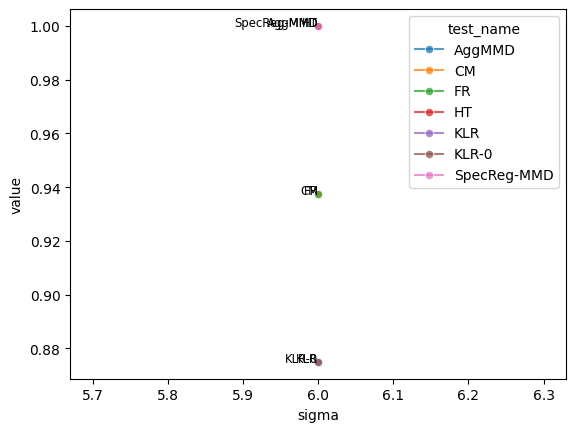

In [20]:
# ridge = [0.1, 0.5, 1, 5, 10]
# ridge = [1e-2,1e-1,1e1,1e2]
band_factor = [0.5,1,5]
ridge = [1e3,1e2,1e1,1,1e-1,1e-2,1e-3]
# -------------------------------- Blurring - Gaussian convolution --------------------------------------------------------------

sigmas = [6]
# sigmas = [2]

results = {}
for sigma in sigmas:
    iter_args = [(np.array([gaussian_filter((_ + np.random.normal(0, .25, _.shape)).reshape(28, 28), sigma).flatten() for _ in X]),
                  np.array([gaussian_filter((_ + np.random.normal(0, .25, _.shape)).reshape(28, 28), sigma).flatten() for _ in Y]),
                  num_permutations, kernel_name, ridge,band_factor )
                 for (X, Y) in XYpairs]

    # iter_args = [(  np.array([_ + np.random.normal(0, sigma, _.shape) for _ in X]),
    #                 np.array([_ + np.random.normal(0, sigma, _.shape) for _ in Y]),
    #                 num_permutations, kernel_name, ridge,band_factor )
    #                  for (X, Y) in XYpairs]
    
    results[sigma] = Parallel(n_jobs=NUM_CORES)( delayed(run_fast)(*args) for args in tqdm(iter_args, total=len(iter_args), ncols=100, position=0))
data = []
for sigma in sigmas:
    for line in results[sigma]:
        for test_name, value in line.items():
            data.append({"sigma": sigma, "test_name": test_name, "value": value})
df = pd.DataFrame(data)
df_blurred = df.groupby(["sigma", "test_name"])["value"].mean().reset_index()
df_blurred.sort_values(['sigma', 'value'])


sns.lineplot(data=df_blurred, x='sigma', y='value', hue='test_name', marker='o', alpha = .75)
for line in df_blurred.itertuples():
    plt.text(line.sigma, line.value, line.test_name, horizontalalignment='right', size='small', color='black')
plt.show()


In [22]:
df_blurred.sort_values(['sigma', 'value'], ascending=[True, False])

,sigma,test_name,value
0,6,AggMMD,1.0000
3,6,HT,1.0000
6,6,SpecReg-MMD,1.0000
1,6,CM,0.9375
2,6,FR,0.9375
4,6,KLR,0.8750
5,6,KLR-0,0.8750


<Axes: >

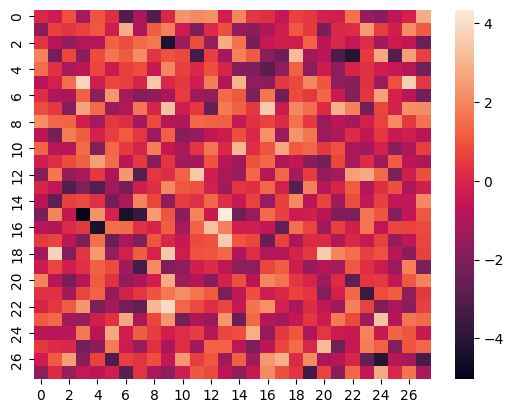

In [16]:
sns.heatmap((XYpairs[0][0][0] + np.random.normal(0, 1.5, 28*28)).reshape(28, 28))

<Axes: >

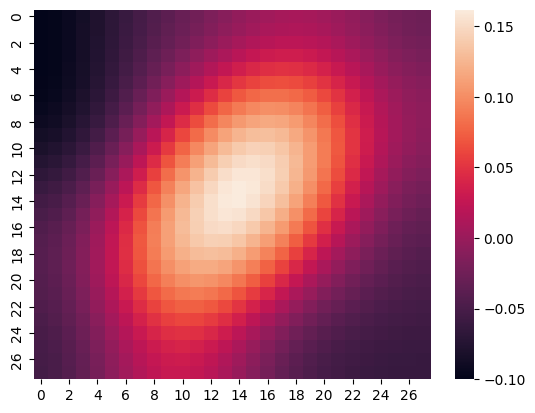

In [19]:
sns.heatmap(gaussian_filter((XYpairs[0][0][0] + np.random.normal(0, .25, 28*28)).reshape(28, 28), 5))
 

In [33]:
v = mnist_data_train.loc[6].sample(1).values